In [3]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [4]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [5]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

# DQN
### 目标值计算公式：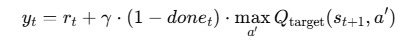

In [6]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        # actions的维度：[batch_size, action_dim]
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        # 将 transition_dict['dones'] 转换为浮点型二维张量（shape (batch_size, 1)），
        # 并移动到模型所在的设备（CPU/GPU）上，以便后续参与计算。
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # .gather(dim, index) 会沿着 指定维度 dim 按索引取值。
        # actions 是一个张量（shape [batch_size, 1]），里面是每个样本实际执行的动作索引（整数）。
        # .gather(1, actions) 会按行取出对应的 Q 值：
        q_values = self.q_net(states).gather(1, actions)  # Q值
        
        # 下个状态的最大Q值
        # .max(dim) 会返回两个东西：最大值（沿指定维度取最大值）、最大值的索引
        # .view(-1, 1) 把张量变成 列向量，方便后续和其他 [batch_size, 1] 形状的张量（比如 rewards, dones）进行运算。
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        
        # 
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        
        # 计算 预测 Q 值 与 目标 Q 值 之间的均方误差，并对 batch 求平均，作为反向传播更新 Q 网络的损失。
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        # 当训练步数/ 迭代次数每达到目标网络更新次数的N倍时，触发目标网络更新，将在线网络的参数拷贝至目标网络
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        
        self.count += 1

# DQN超参数、环境设置和训练

In [18]:
# 超参数
lr = 2e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# 环境与随机种子
env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)

# DQN相关
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            # state = env.reset(seed=0)
            state, _ = env.reset(seed=0) # 最新Gym设置
            done = False
            while not done:
                action = agent.take_action(state)
                # next_state, reward, done, _ = env.step(action)
                next_state, reward, done_flag, truncated, _ = env.step(action)  # 最新Gym返回5个值
                done = done_flag or truncated  # 合并 done 和 truncated
                # 放入经验回放池
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

d:\anaconda3\envs\DRL\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]d:\anaconda3\envs\DRL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s, episode=1000, return=200.000]


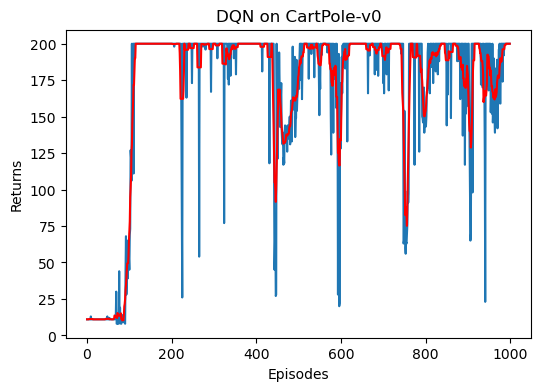

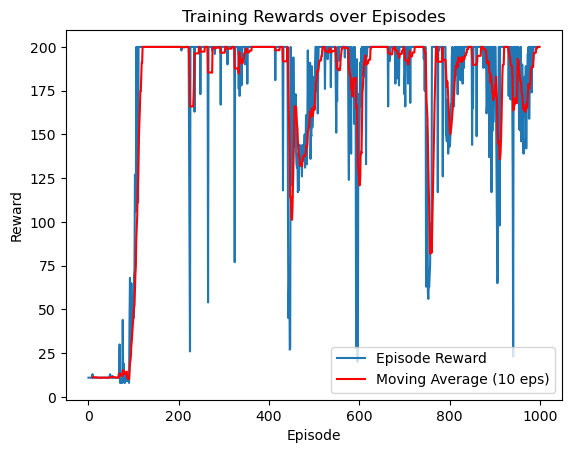

In [20]:
plt.figure(figsize=(6, 4))

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return, color='red')
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

# 可视化训练奖励
# -----------------------------
plt.plot(return_list, label='Episode Reward')
# 用滑动平均平滑曲线
window = 10
moving_avg = np.convolve(return_list, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(return_list)), moving_avg, label='Moving Average (10 eps)', color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Rewards over Episodes')
plt.legend()
plt.show()

# # -----------------------------
# # 渲染训练好的智能体
# # -----------------------------
# state, _ = env.reset(seed=0) # 最新Gym设置
# done = False
# while not done:
#     env.render()  # 渲染
#     action = agent.take_action(state)
#     next_state, reward, done_flag, truncated, _ = env.step(action)  # 最新Gym返回5个值
#     done = done_flag or truncated  # 合并 done 和 truncated
# env.close()

In [17]:
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

# 创建环境
env = gym.make('CartPole-v0', render_mode=None)  # render_mode=None，完全用 matplotlib 可视化
state, _ = env.reset(seed=0)

# 保存每一步状态
states = []

done = False
while not done:
    states.append(state)
    # 随机动作示例（你可以换成 agent.take_action(state)）
    action = env.action_space.sample()
    state, reward, done_flag, truncated, _ = env.step(action)
    done = done_flag or truncated

env.close()

# -----------------------------
# Matplotlib 动画可视化
# -----------------------------
cart_width = 0.4
cart_height = 0.2
pole_length = 0.6

fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlim(-2.4, 2.4)
ax.set_ylim(-0.5, 1.0)

cart_patch = plt.Rectangle((0,0), cart_width, cart_height, color='blue')
pole_line, = ax.plot([], [], lw=4, color='red')

ax.add_patch(cart_patch)

def init():
    cart_patch.set_xy((-cart_width/2, 0))
    pole_line.set_data([], [])
    return cart_patch, pole_line

def animate(i):
    x = states[i][0]  # 小车位置
    theta = states[i][2]  # 杆子角度
    # 更新小车位置
    cart_patch.set_xy((x - cart_width/2, 0))
    # 更新杆子位置
    pole_x = [x, x + pole_length * np.sin(theta)]
    pole_y = [cart_height/2, cart_height/2 + pole_length * np.cos(theta)]
    pole_line.set_data(pole_x, pole_y)
    return cart_patch, pole_line

ani = animation.FuncAnimation(fig, animate, frames=len(states),
                              init_func=init, blit=True, interval=50)

plt.close()  # 防止输出静态图
from IPython.display import HTML
HTML(ani.to_jshtml())


d:\anaconda3\envs\DRL\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
d:\anaconda3\envs\DRL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# 引入卷积层的DQN

In [ ]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)